<a href="https://colab.research.google.com/github/valmirf/redes_neurais_ple/blob/master/SOM/Self_Organising_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
!git clone https://github.com/valmirf/redes_neurais_ple.git

fatal: destination path 'redes_neurais_ple' already exists and is not an empty directory.


# Self-Organizing Maps Network

Código exemplo da rede neural SOM.

Código adaptado do site:

http://blog.yhat.com/posts/self-organizing-maps-2.html

In [129]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from sklearn import preprocessing

##Configuração da SOM

Escolhe:
1. Tamanho do mapa da SOM: X e Y
2. Número de iterações
3. Taxa de aprendizado
4. Tipo de normalização dos dados
5. Largura inicial (Sigma) 
6. Constante de tempo que descresce com o tempo

In [130]:
X = 5
Y = 5
network_dimensions = np.array([X, Y])
label_map = np.zeros((X,Y,3))

n_iterations = 10000
init_learning_rate = 0.1

normalize_data = True
# se True, normaliza em relação a toda a base de dados
# se False, normaliza entre [0 1] levando em conta cada coluna
normalize_by_column = False

#cria raio inicial de acordo com o tamanho inicial do mapa da SOM
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2

#constante de tempo que decai com o tempo
time_constant = n_iterations / np.log(init_radius)

## Carrega base de dados

Carrega base de dados e retorna os dados normalizados. 

Note que não há divisão entre treinamento e teste, pois se trata de um problema não supervisionado. Toda a base de dados é utilizada pra treinar o modelo.

In [131]:
#carrega a base de dados
def load_data(url, normalize_data,normalize_by_column):
    df = pd.read_csv(url,  header=None)
    #remove a ultima coluna (dados)
    data = df[df.columns[:-1]]
    
    #retorna a última coluna (rótulos)
    labels = df[df.columns[-1]]

    # check if data needs to be normalised
    if normalize_data:
      if normalize_by_column:
        # normalise along each column
        col_maxes = data.max(axis=0)
        normalized_data = (data - col_maxes.min()) / (col_maxes.max() - col_maxes.min())
      else:
        # normalise entire dataset
        normalized_data = (data - data.min()) / (data.max() - data.min())

    return normalized_data, labels

Rede Neural SOM

In [132]:
def find_bmu(t, net, m):
    """
        Encontra o neurônio vencedor pra um dado vetor de entrada, t, na rede SOM
        Retorna: (bmu, bmu_idx) onde bmu é o neurônio vencedor BMU
                 e bmu_idx é a coordenada do vetor na rede SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    # define um número grande pra distância mínima inicial 
    min_dist = np.iinfo(np.int).max   
    # calcula a distância entre cada neurônio e a entrada
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # obtém o vetor correspondente a bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # retorna (bmu, bmu_idx)
    return (bmu, bmu_idx)

In [133]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [134]:
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [135]:
#neighborhood
def compute_neighborhood(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

Aprendizado SOM

## Algoritmo da rede SOM


Etapa 0: posicione aleatoriamente os neurônios no mapa da rede SOM.

Etapa 1: selecione um exemplo da base de dados, aleatoriamente ou sistematicamente no conjunto de dados

Etapa 2: encontre o neurônio mais próximo do ponto de dados escolhido. Esse neurônio é chamado de Unidade de Melhor Similaridade (BMU - Best Unit Matching).

Etapa 3: Mova a BMU para mais perto desse ponto de dados. A distância movida pela BMU é determinada por uma taxa de aprendizado, que diminui após cada iteração.

Etapa 4: aproxime também os vizinhos da BMU desse ponto de dados, com os vizinhos mais distantes se movendo menos. Os vizinhos são identificados usando um raio ao redor da BMU (função de vizinhança), e o valor desse raio diminui após cada iteração.

Etapa 5: atualize a taxa de aprendizado e o raio da BMU, antes de repetir as etapas 1 a 4. Repita essas etapas até que as posições dos neurônios tenham sido estabilizadas.

In [138]:
local = 'redes_neurais_ple/RBF/iris.csv'

data,labels = load_data(local, normalize_data,normalize_by_column)

# pega tamanho da base de dados
m = data.shape[1]
n = data.shape[0]

#transforma rótulos do conjunto de treinamento em numeros pra mostrar no mapa
le = preprocessing.LabelEncoder()
le.fit(labels.values)
training_labels_transformed = le.transform(labels.values)
c = le.classes_

# inicialização dos pesos m=dimensional pra cada neurônio da matriz SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

for i in range(n_iterations):
    
    #print('Iteration %d' % i)
    
    #seleciona um exemplo aleatoriamente da base de dados
    random_example = np.random.randint(0, n)
    t = data.iloc[random_example].values.reshape(np.array([m, 1]))
  
    #calcula neurônio mais próximo a este exemplo (BMU)
    bmu, bmu_idx = find_bmu(t, net, m)
    
    #seleciona a classe do exemplo (Apenas pra vias de informação no mapa)
    class_index = list(c).index(labels[random_example])
    
    lab = label_map[bmu_idx[0],bmu_idx[1]]  
    lab[class_index] = lab[class_index]+1
    #associa o neurônio a esta classe
    label_map[bmu_idx[0],bmu_idx[1]] = lab
    
    # Decresce os parâmetros da SOM
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # Atualiza o vetor de Pesos da rede SOM para todos os neurônios da rede
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # calcula a distância do neurônio ao neurônio vencedor
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # se distância está dentro do raio estipulado r^2
            if w_dist <= r**2:
                # calcula a função de vizinhança
                influence = compute_neighborhood(w_dist, r)
                # atualiza os pesos
                # w(t+1) = w(t) + (learning rate * h * distancia)
                new_w = w + (l * influence * (t - w))
                # coloca o novo peso na rede na posição X,Y
                net[x, y, :] = new_w.reshape(1, m)

            0         1         2         3
0    0.222222  0.625000  0.067797  0.041667
1    0.166667  0.416667  0.067797  0.041667
2    0.111111  0.500000  0.050847  0.041667
3    0.083333  0.458333  0.084746  0.041667
4    0.194444  0.666667  0.067797  0.041667
..        ...       ...       ...       ...
145  0.666667  0.416667  0.711864  0.916667
146  0.555556  0.208333  0.677966  0.750000
147  0.611111  0.416667  0.711864  0.791667
148  0.527778  0.583333  0.745763  0.916667
149  0.444444  0.416667  0.694915  0.708333

[150 rows x 4 columns]


## Visualiza o mapa criado

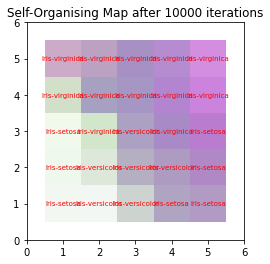

In [139]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        m = label_map[x-1,y-1]
        name_class = c[np.argmax(m)]
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none',label='sdsad'))
        ax.text(x,y, name_class,
         horizontalalignment='center', verticalalignment='center',
         fontsize=7, color='red')
plt.show()

#Mini-Projeto 2:

Execute a Redes Neurais SOM acima com a base de dados MNist que possui caracteres de 0 a 9. Mostre os resultados abaixo:

1. Mostre 5 configurações de mapa diferentes
2. Escolha uma vizinhança diferente da padrão (Ver Slide 16). Construa os mesmos 5 mapas da questão anterior.
3. Utilize um índice para avaliação de algoritmos não supervisionados para avaliar os resultados dos mapas. (Ex: Índice de Rand, índice de Hartigan, F-Measure, Jaccard, Índice de Rand)

Ver artigo: Evaluation Metrics for Unsupervised Learning
Algorithms na pasta da rede SOM do github.

DATA DE ENTREGA: 17/09/2020


